# Introduction

## Imports

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns
from reglin.metrics.errors import erreur_pour_plusieurs_parametres
from mpl_toolkits import mplot3d
from cloud_io.gcp.io import download_file
from reglin.tools.common_path import ROOT_PATH, BUCKET_NAME
import matplotlib
from IPython.display import display, HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
matplotlib.rcParams.update({'font.size': 22})


## Rappel sur les fonctions

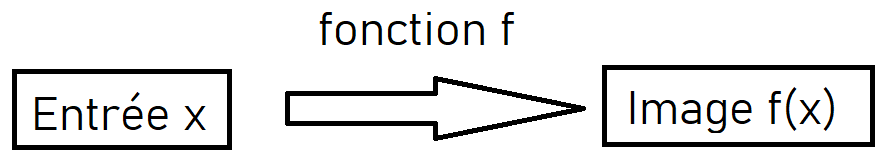

In [ ]:
VERBOSE = True

In [ ]:
## Exemple de fonctions 

fonctions = [np.cos, np.exp, lambda x: 2 * x + 3]
X = [np.linspace(-2 * np.pi, 2 * np.pi, 100), np.linspace(-2, 3, 100), np.linspace(-10, 10, 100)]
titles = ['f(x) = Cos(x)', 'f(x) = exp(x)', 'f(x) = 2x + 3' ]

if VERBOSE:
    plt.figure(figsize = (30, 7))
    for k in range(len(fonctions)):
        plt.subplot(1, 3, k+1)
        plt.plot(X[k], fonctions[k](X[k]))
        plt.title(titles[k])
        plt.grid(True)


## Contexte


Une problématique du *Machine Learning* est de permettre à la machine de comprendre la relation entre différentes variables. Cette compréhension lui permettra de faire des prédictions.


Etant donné deux variables X et Y:

In [ ]:
np.random.seed(42)

X = np.random.randn(50)
Y = 3 * X + np.random.randn(50) / 0.5

if VERBOSE:
    plt.figure(figsize=(12, 7))
    plt.grid(True)

    plt.scatter(X, Y)
    plt.ylabel('Y')
    plt.xlabel('X')


Un problème de régression peut se représenter comme un processus d’entrée/sortie:

Trouver "le bon" $\hat{f}$ tel que $$ Y \simeq \hat{f}(X) $$


X est la variable explicative et Y qui est une information continue, est la variable à expliquer.

C'est une tâche complexe de trouver $\hat{f}$ parmi l'ensemble de toutes les fonctions possibles. Nous allons donc chercher $\hat{f}$ parmi les fonction affines.

In [ ]:
params = [(2, 3), (3, 0), (1, -2)]

if VERBOSE:
    plt.figure(figsize=(40, 7))
    plt.grid(True)

    for k in range(len(params)):
        plt.subplot(1, 3, k+1)
        plt.grid(True)
        plt.scatter(X, Y, label='échantillon')
        plt.ylabel('Y')
        plt.xlabel('X')

        plt.plot(np.linspace(-3, 3, 100), params[k][0] * np.linspace(-3, 3, 100) + params[k][1], label='prédiction', color='red')

        plt.title('Modèle $\hat{f}$ ' + str(k))
        plt.legend()

Points extrémaux

In [ ]:
X = np.random.randn(50)
Y = 3 * X + np.random.randn(50) / 0.5

X = np.hstack((X, np.array([1, -1])))
Y = np.hstack((Y, np.array([20, -30])))

params = [ (3, 0), (13, 0)]

if VERBOSE:
    plt.figure(figsize=(40, 7))
    plt.grid(True)

    for k in range(len(params)):
        plt.subplot(1, 3, k+1)
        plt.grid(True)
        plt.scatter(X, Y, label='échantillon')
        plt.ylabel('Y')
        plt.xlabel('X')

        plt.plot(np.linspace(-3, 3, 100), params[k][0] * np.linspace(-3, 3, 100) + params[k][1], label='prédiction', color='red')

        plt.title('Modèle $\hat{f}$ ' + str(k))
        plt.legend()

Aujourd'hui, nous allons sur un dataset données:

- visualiser les donner
- prétraiter les données
- entraîner le modèle pour fitter les données

# Sujet: la consommation de poulet 

Quelle est la relation entre la population et le nombre de poulet d’élevage?

## Description des données
<a name="Desc"></a>

In [ ]:
FIGSIZE = (10,8)

PREDICTOR_COL = "Population"
TARGET_COL = "taille du bétail"

## 0 - chargez et faites une rapide analyse descriptive

In [ ]:
csv_kwargs = dict(sep=";", encoding = "ISO-8859-1")

In [ ]:
download_path = Path(ROOT_PATH, "data/chicken.csv")
path_data = download_file(download_path, bucket_as_local=ROOT_PATH, bucket_name=BUCKET_NAME)

In [ ]:
chicken = pd.read_csv(
    path_data,
    **csv_kwargs,
)

In [ ]:
if VERBOSE:
    display(chicken.head())

Nous avons quatre variables dans la base de données. Une ligne de la base donne la population et la taille du bétail d’un certain nombre de pays. 

In [ ]:
if VERBOSE:
    sample_country = "TCD"
    display(chicken.query("Code == @sample_country"))

In [ ]:
chicken[chicken.Pays == "Bénin"]

In [ ]:
expected_shape = (27, 5)
np.testing.assert_allclose(chicken.shape, expected_shape)

In [ ]:
if VERBOSE:
    display(chicken.describe())

## 1 - Identification des valeurs extrêmes

In [ ]:
max_pop = max(chicken.Population)
chicken[chicken.Population == max_pop]

In [ ]:
df_chicken_sorted = chicken.sort_values(by=TARGET_COL, ascending=False)
highests = df_chicken_sorted.head(2)

In [ ]:
highests

In [ ]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.boxplot(y=TARGET_COL, x="Unit", data=chicken, ax=ax)
    plt.show()

In [ ]:
expected_code_countries = {18: 'MAR', 25: 'TUN'}
assert highests["Code"].to_dict() == expected_code_countries

## 2 - visualisation de la relation entre les variables

In [ ]:
outliers_labels = {}
for outlier in highests.to_dict(orient="records"):
    outlier_label = dict(
        x=outlier[PREDICTOR_COL]+100,
        y=outlier[TARGET_COL]+10,
        s=outlier["Pays"]
    )
    outliers_labels[outlier["Code"]] = outlier_label

In [ ]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.scatterplot(data=chicken, x=PREDICTOR_COL, y=TARGET_COL, ax=ax)
    for country_code in outliers_labels:
        plt.text(**outliers_labels[country_code])

    plt.show()

## Construction du modèle
<a name="Construction"></a>

On élimine les outliers Tunisie et Maroc

In [ ]:
df = chicken.drop(highests.index)
X, y = df[[PREDICTOR_COL]], df[TARGET_COL]

In [ ]:
assert "MAR" not in df["Code"] and "TUN" not in df["Code"]

## 3 - Calibrage et prédiction du modèle

In [ ]:
regressor = LinearRegression()
# Calibrage du modèle: détermination des coefficient
regressor.fit(X, y)

In [ ]:
Y_model = regressor.predict(X)

In [ ]:
expected_Y_model = [
    19039.50424144, 29456.62073701, 18587.14761474, 36436.9298933 ,
    24030.48360293, 11160.48285208, 36269.88352178,  7203.26661398,
    7396.94015841, 42355.35466942, 20198.82887378,  6895.77505979,
    7237.81113218, 10629.79205785, 13070.3403772 , 37741.97317476,
    28572.00615962, 10084.57617003, 41741.52785203,  7642.11152571,
    32586.64588714, 23474.87408821, 57545.54294173, 14522.52623467,
    57999.05456022
]
np.testing.assert_allclose(Y_model, expected_Y_model)

In [ ]:
# Visualisation
if VERBOSE:
    fig, ax = plt.subplots(1,1, figsize=FIGSIZE)
    ax.plot(df[PREDICTOR_COL], df[TARGET_COL], "o", label='échantillon')
    ax.plot(df[[PREDICTOR_COL]], Y_model, label='prédiction')
    plt.xlabel(PREDICTOR_COL)
    plt.legend()
    plt.ylabel(TARGET_COL)
    plt.show()


## 2 - Description de l'erreur (approfondissement)

In [ ]:
DIM_X = 200
DIM_Y = 200

coeff = np.linspace(0,0.002,DIM_X)
intercept = np.linspace(2000,10700,DIM_Y)

coeff_matrix, intercept_matrix = np.meshgrid(coeff, intercept)

In [ ]:
erreur_quadratique = erreur_pour_plusieurs_parametres(
    coefficient_matrix = coeff_matrix, intercept_matrix = intercept_matrix, df = df, predictor_col = PREDICTOR_COL, target_col = TARGET_COL
)

In [ ]:
coeff_matrix.shape

In [ ]:
intercept_matrix.shape

In [ ]:
erreur_quadratique.shape

In [ ]:
if VERBOSE:

    plt.figure(figsize=FIGSIZE)

    ax = plt.axes(projection='3d')
    ax.plot_surface(coeff_matrix, intercept_matrix, erreur_quadratique, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_title("surface de l'erreur");

## Qu'est-ce qu'on retient? 

1. La Régression linéaire est un modèle où l'espérance de variable à expliquer est une fonction affine des paramètres
2. La moyenne est très sensible au valeur extrême. Il faut donc les identifier et les traiter
3. Le calibrage du modèle est une réduction (optimisation) de l'erreur quadratique

## Pour aller plus loin

1. Quels sont les hypothèses de la regression linéaire?
2. Comment les tester?
3. Que ferait-on si l'on avait plusieurs variables axplicatives?
4. Qu'aurait-on eu si nous avions gardé les valeurs aberrantes?

---
# End of script
---